In [19]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.ldamodel import LdaModel
from collections import Counter
from operator import itemgetter

from top2vec import Top2Vec


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load process_csv_stage_1.csv

In [2]:
df = pd.read_csv('process_csv_stage_1.csv')
df.columns = ['old_index','preprocessed_text']
df

old_index                                  preprocessed_text
0              1  good morning name appreciate could help put st...
1              2  upgraded card tell agent upgrade anniversary d...
2             10  chase card report however fraudulent applicati...
3             11  try book ticket come across offer apply toward...
4             14  grand son give check deposit chase account fun...
...          ...                                                ...
21067      78303  chase card customer well decade offer multiple...
21068      78309  wednesday call chas visa credit card provider ...
21069      78310  familiar pay understand great risk provide con...
21070      78311  flawless credit chase credit card chase freedo...
21071      78312  roughly year ago close account morgan chase ba...

[21072 rows x 2 columns]

# Load complaint_what_happened from json

In [3]:
# load raw complaint json into raw df 
raw = pd.json_normalize(json.load(open("complaints-2021-05-14_08_16_.json")))

# renaming column
raw.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

# drop unnecessary columns
raw.drop(['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'sub_issue','consumer_consent_provided'],axis=1,inplace=True)

# drop null values
raw['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
raw.dropna(inplace=True)

# clear masked values
def remove_mask(text):
    masked_text_pattern = r"\b[x|X]{2,20}"
    return re.sub(masked_text_pattern,'',text)

removed_mask = raw.complaint_what_happened.apply(remove_mask)

# Topic Modelling

## Non-Negative Matrix Factorisation

k = 2; Coherence Score = 0.34957
k = 3; Coherence Score = 0.37618
k = 4; Coherence Score = 0.43068
k = 5; Coherence Score = 0.38438
k = 6; Coherence Score = 0.41864
k = 7; Coherence Score = 0.39968
k = 8; Coherence Score = 0.40657
k = 9; Coherence Score = 0.4196


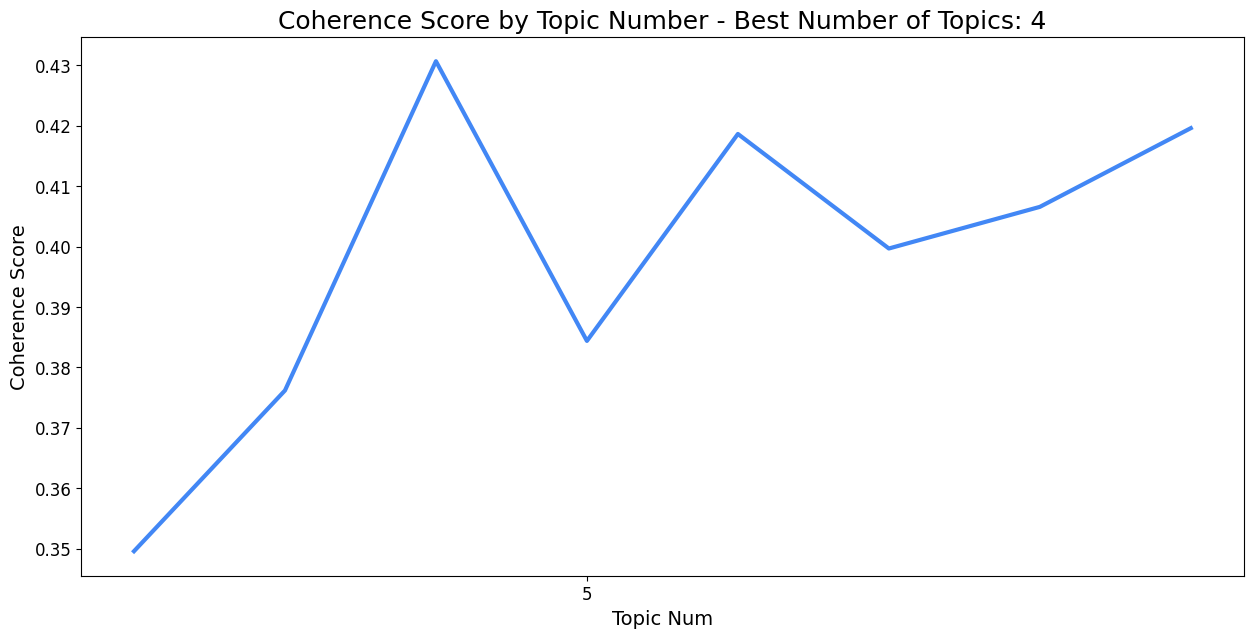

In [4]:
texts = df['preprocessed_text'].str.split(' ')

dictionary = Dictionary(texts)

dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

corpus = [dictionary.doc2bow(text) for text in texts]

topic_nums = list(np.arange(2, 10, 1))

coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    print(f'k = {num}; Coherence Score = {round(cm.get_coherence(), 5)}')

scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [5]:
final_nmf = Nmf(
        corpus=corpus,
        num_topics=best_num_topics,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
final_nmf.print_topics()

[(0,
  '0.037*"payment" + 0.022*"pay" + 0.018*"loan" + 0.018*"charge" + 0.017*"make" + 0.013*"mortgage" + 0.011*"time" + 0.009*"month" + 0.009*"fee" + 0.009*"interest"'),
 (1,
  '0.034*"call" + 0.021*"tell" + 0.019*"would" + 0.019*"say" + 0.017*"bank" + 0.014*"get" + 0.014*"back" + 0.013*"ask" + 0.011*"day" + 0.010*"could"'),
 (2,
  '0.073*"credit" + 0.035*"report" + 0.018*"consumer" + 0.018*"card" + 0.014*"information" + 0.014*"request" + 0.013*"act" + 0.012*"debt" + 0.011*"reporting" + 0.010*"agency"'),
 (3,
  '0.108*"account" + 0.054*"card" + 0.023*"bank" + 0.020*"check" + 0.018*"credit" + 0.018*"close" + 0.015*"transaction" + 0.014*"charge" + 0.014*"open" + 0.012*"fraud"')]

In [6]:
nmf_topics = []
for index, topic in final_nmf.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    nmf_topics.append([w[0] for w in topic])

Topic: 0 
Words: ['payment', 'pay', 'loan', 'charge', 'make', 'mortgage', 'time', 'month', 'fee', 'interest']
Topic: 1 
Words: ['call', 'tell', 'would', 'say', 'bank', 'get', 'back', 'ask', 'day', 'could']
Topic: 2 
Words: ['credit', 'report', 'consumer', 'card', 'information', 'request', 'act', 'debt', 'reporting', 'agency']
Topic: 3 
Words: ['account', 'card', 'bank', 'check', 'credit', 'close', 'transaction', 'charge', 'open', 'fraud']


## Latent Dirichlet Allocation

k = 2; Coherence Score = 0.35391
k = 3; Coherence Score = 0.369
k = 4; Coherence Score = 0.39821
k = 5; Coherence Score = 0.40116
k = 6; Coherence Score = 0.41403
k = 7; Coherence Score = 0.40698
k = 8; Coherence Score = 0.42394
k = 9; Coherence Score = 0.42162


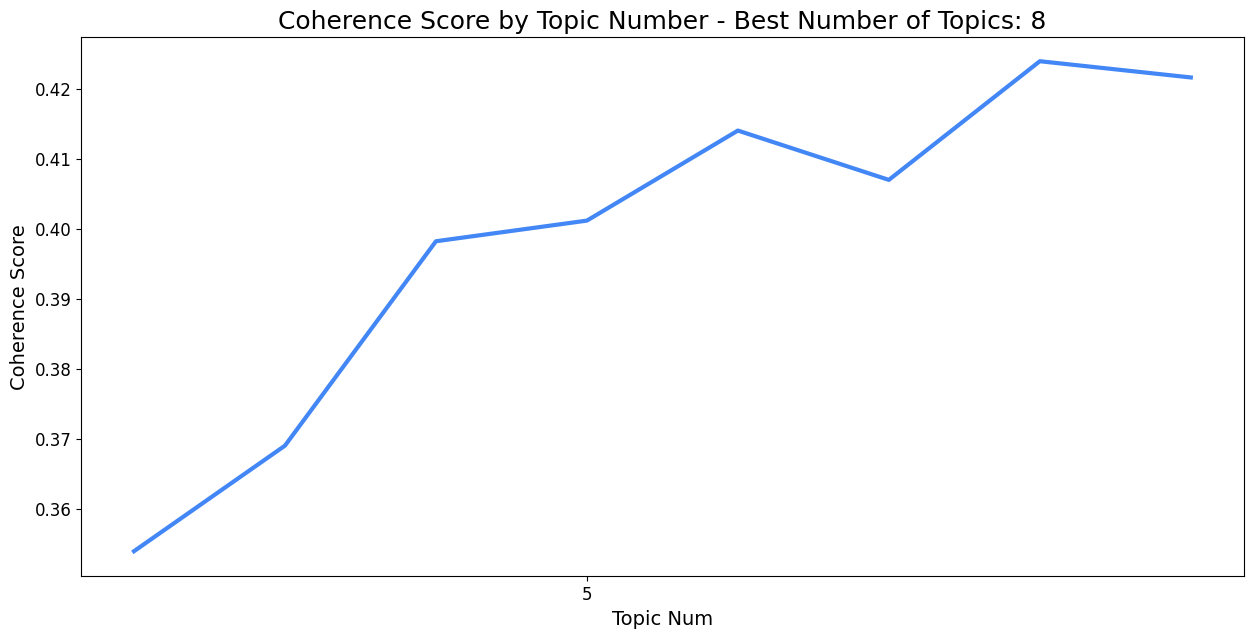

In [7]:
texts = df['preprocessed_text'].str.split(' ')

dictionary = Dictionary(texts)

dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

corpus = [dictionary.doc2bow(text) for text in texts]

topic_nums = list(np.arange(2, 10, 1))

coherence_scores = []

for num in topic_nums:
    lda = LdaModel(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        minimum_probability=0.01,
        alpha='symmetric',
        eta= 0.7,
        per_word_topics=True,
        eval_every=10,
        random_state=42
    )
    cm = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    print(f'k = {num}; Coherence Score = {round(cm.get_coherence(), 5)}')

scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [8]:
final_lda = LdaModel(
    corpus=corpus,
    num_topics=best_num_topics,
    id2word=dictionary,
    chunksize=2000,
    passes=5,
    minimum_probability=0.01,
    alpha='symmetric',
    eta= 0.7,
    per_word_topics=True,
    eval_every=10,
    random_state=42
)
final_lda.print_topics()

[(0,
  '0.060*"card" + 0.033*"credit" + 0.022*"charge" + 0.017*"dispute" + 0.015*"receive" + 0.012*"would" + 0.011*"purchase" + 0.009*"offer" + 0.009*"call" + 0.009*"service"'),
 (1,
  '0.038*"charge" + 0.036*"transaction" + 0.030*"account" + 0.026*"bank" + 0.023*"claim" + 0.019*"fee" + 0.018*"card" + 0.016*"fraud" + 0.016*"make" + 0.013*"money"'),
 (2,
  '0.090*"credit" + 0.059*"report" + 0.039*"account" + 0.030*"card" + 0.019*"information" + 0.014*"inquiry" + 0.013*"remove" + 0.013*"letter" + 0.010*"request" + 0.009*"company"'),
 (3,
  '0.076*"payment" + 0.044*"pay" + 0.032*"credit" + 0.029*"balance" + 0.021*"interest" + 0.020*"make" + 0.020*"late" + 0.019*"account" + 0.017*"fee" + 0.015*"due"'),
 (4,
  '0.095*"account" + 0.052*"check" + 0.039*"bank" + 0.021*"close" + 0.020*"deposit" + 0.019*"fund" + 0.015*"branch" + 0.013*"money" + 0.012*"open" + 0.012*"would"'),
 (5,
  '0.039*"call" + 0.024*"say" + 0.023*"tell" + 0.020*"get" + 0.018*"would" + 0.015*"back" + 0.014*"ask" + 0.013*"sen

In [9]:
lda_topics = []
for index, topic in final_lda.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    lda_topics.append([w[0] for w in topic])

Topic: 0 
Words: ['card', 'credit', 'charge', 'dispute', 'receive', 'would', 'purchase', 'offer', 'call', 'service']
Topic: 1 
Words: ['charge', 'transaction', 'account', 'bank', 'claim', 'fee', 'card', 'fraud', 'make', 'money']
Topic: 2 
Words: ['credit', 'report', 'account', 'card', 'information', 'inquiry', 'remove', 'letter', 'request', 'company']
Topic: 3 
Words: ['payment', 'pay', 'credit', 'balance', 'interest', 'make', 'late', 'account', 'fee', 'due']
Topic: 4 
Words: ['account', 'check', 'bank', 'close', 'deposit', 'fund', 'branch', 'money', 'open', 'would']
Topic: 5 
Words: ['call', 'say', 'tell', 'get', 'would', 'back', 'ask', 'send', 'phone', 'could']
Topic: 6 
Words: ['loan', 'mortgage', 'payment', 'home', 'pay', 'year', 'time', 'modification', 'would', 'property']
Topic: 7 
Words: ['bank', 'provide', 'complaint', 'state', 'document', 'request', 'consumer', 'claim', 'service', 'law']


In [10]:
print('\nPerplexity: ', final_lda.log_perplexity(corpus))  

coherence_model_lda = CoherenceModel(model=final_lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.584655071181638

Coherence Score:  0.42393758178227053


In [11]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
coherence_per_topic 

[0.3550784343137411,
 0.4241518437854349,
 0.4360410665440925,
 0.45577692985384166,
 0.42857970907526477,
 0.43267301686917853,
 0.47020484568790444,
 0.38899480812870624]

C:\Users\dxlee\AppData\Local\Temp\ipykernel_23800\694781211.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


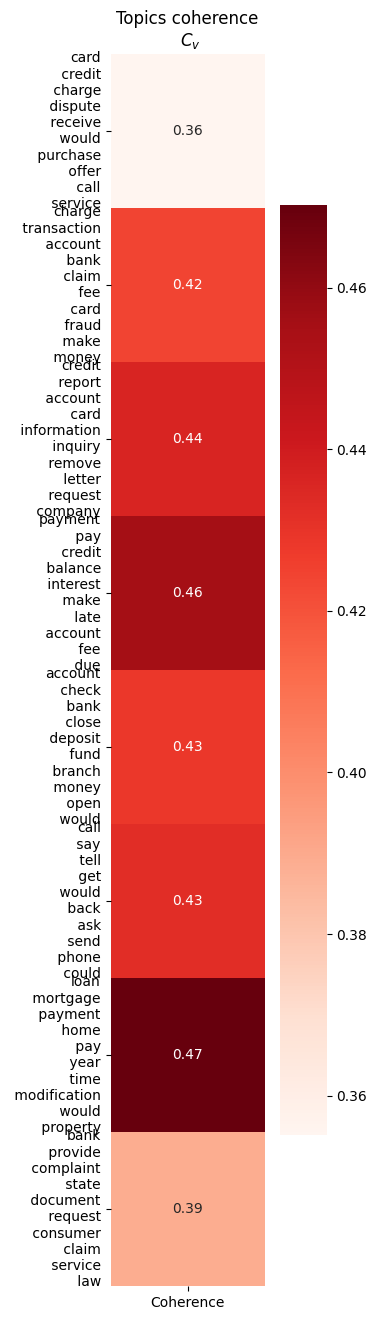

In [12]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
topics_str = [ '\n '.join(t) for t in lda_topics ]
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(4, 16) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

## Top2Vec

In [13]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42}
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

top2vec = Top2Vec(
    documents= list(removed_mask), 
    speed='deep-learn', 
    workers=8, 
    min_count = 0, 
    embedding_model='universal-sentence-encoder', 
    umap_args = umap_args, 
    hdbscan_args = hdbscan_args)

top2vec.get_num_topics()

2024-06-02 18:53:44,387 - top2vec - INFO - Pre-processing documents for training
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-06-02 18:53:58,516 - top2vec - INFO - Downloading universal-sentence-encoder model
2024-06-02 19:00:27,954 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-06-02 19:01:07,525 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
c:\Users\dxlee\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-06-02 19:02:04,906 - top2vec - IN

7

In [14]:
top2vec.topic_words

array([['chexsystems', 'cfpb', 'autopay', 'bofa', 'lifelock', 'usaa',
        'citibank', 'repoed', 'chase', 'wamu', 'overdrawn', 'kyc',
        'wellsfargo', 'transunion', 'garnishment', 'preapproval', 'pnc',
        'experian', 'chargebacks', 'echeck', 'churning', 'defaulted',
        'citi', 'overdrafted', 'garnishments', 'overdrafts',
        'chargeback', 'overdraft', 'garnished', 'refinanced', 'bank',
        'defrauded', 'fdic', 'creditor', 'creditors', 'heloc', 'banking',
        'reposession', 'refi', 'insolvent', 'equifax', 'creditcard',
        'debtors', 'amex', 'receivables', 'santander', 'overdraw',
        'fraudsters', 'lender', 'hsbc'],
       ['experian', 'dispute', 'lifelock', 'transunion', 'garnishment',
        'creditor', 'chexsystems', 'equifax', 'defrauded', 'repoed',
        'receivables', 'disputes', 'garnished', 'creditors', 'disputing',
        'litigation', 'garnishing', 'collections', 'fraudulent',
        'bureaus', 'autopay', 'forclosure', 'debtor', 'bai

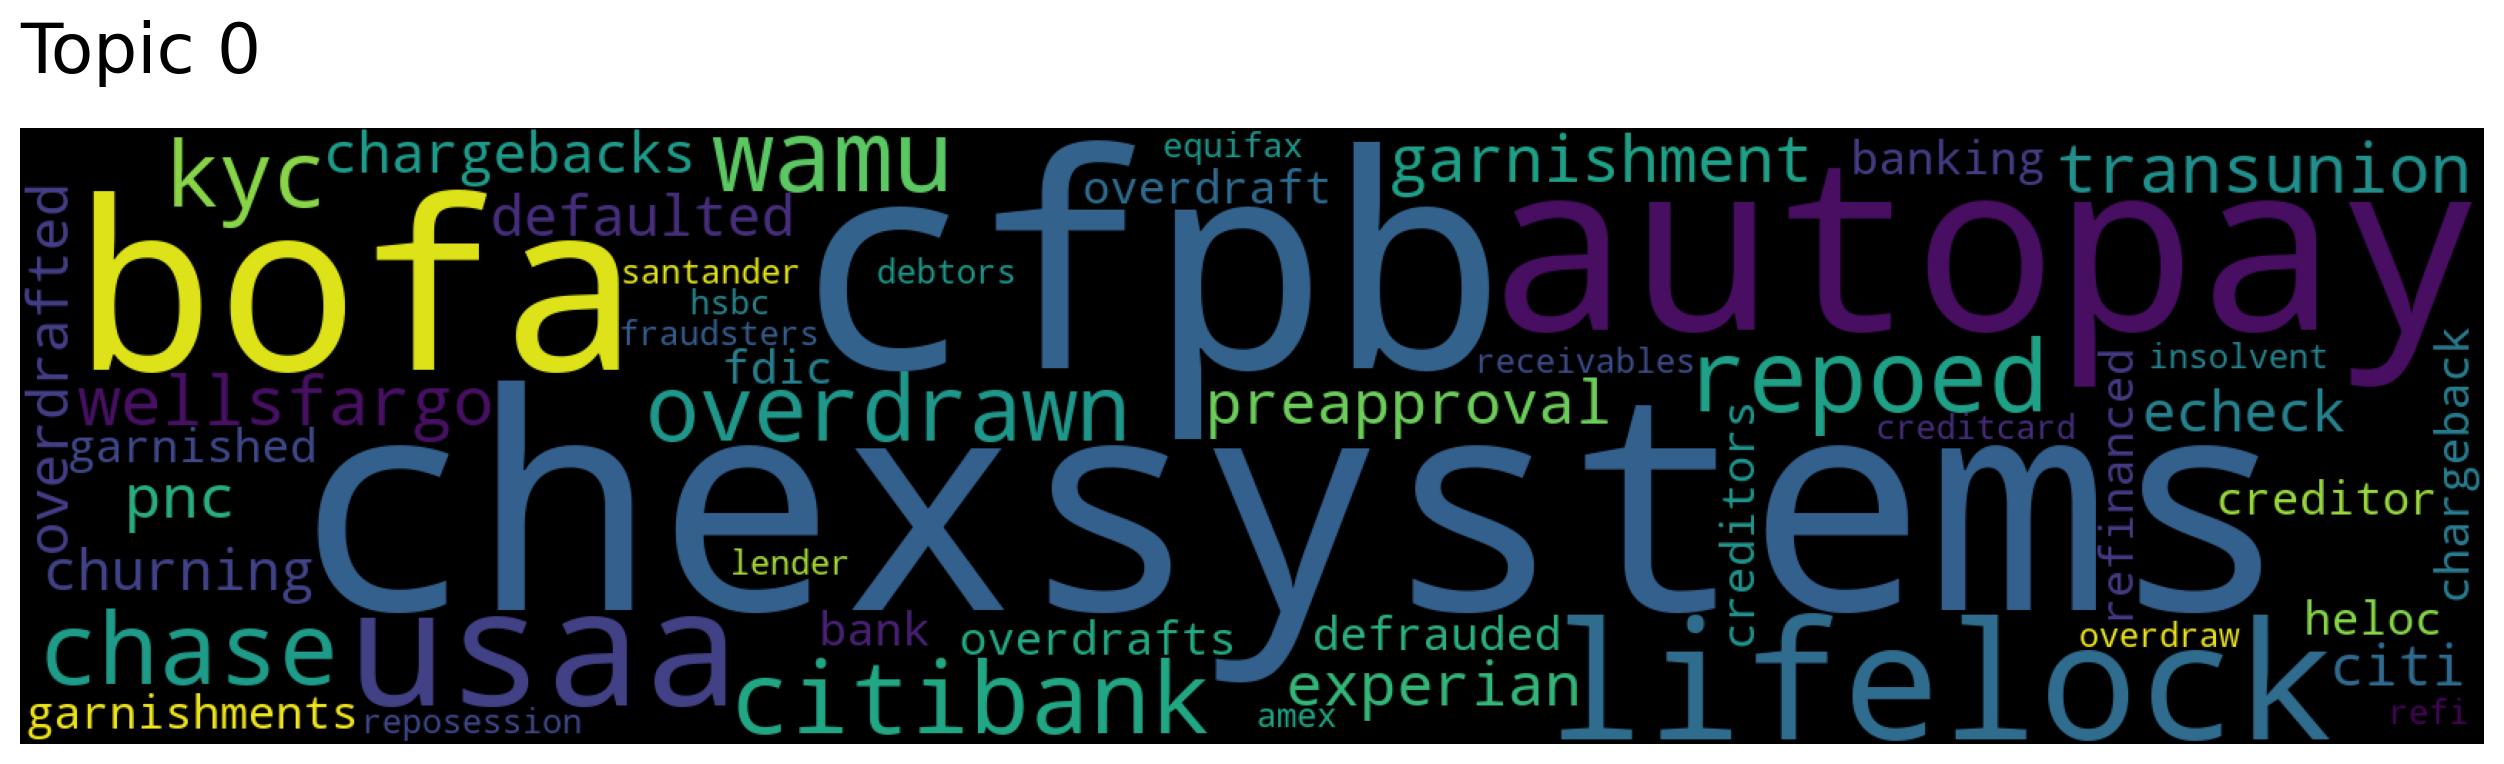

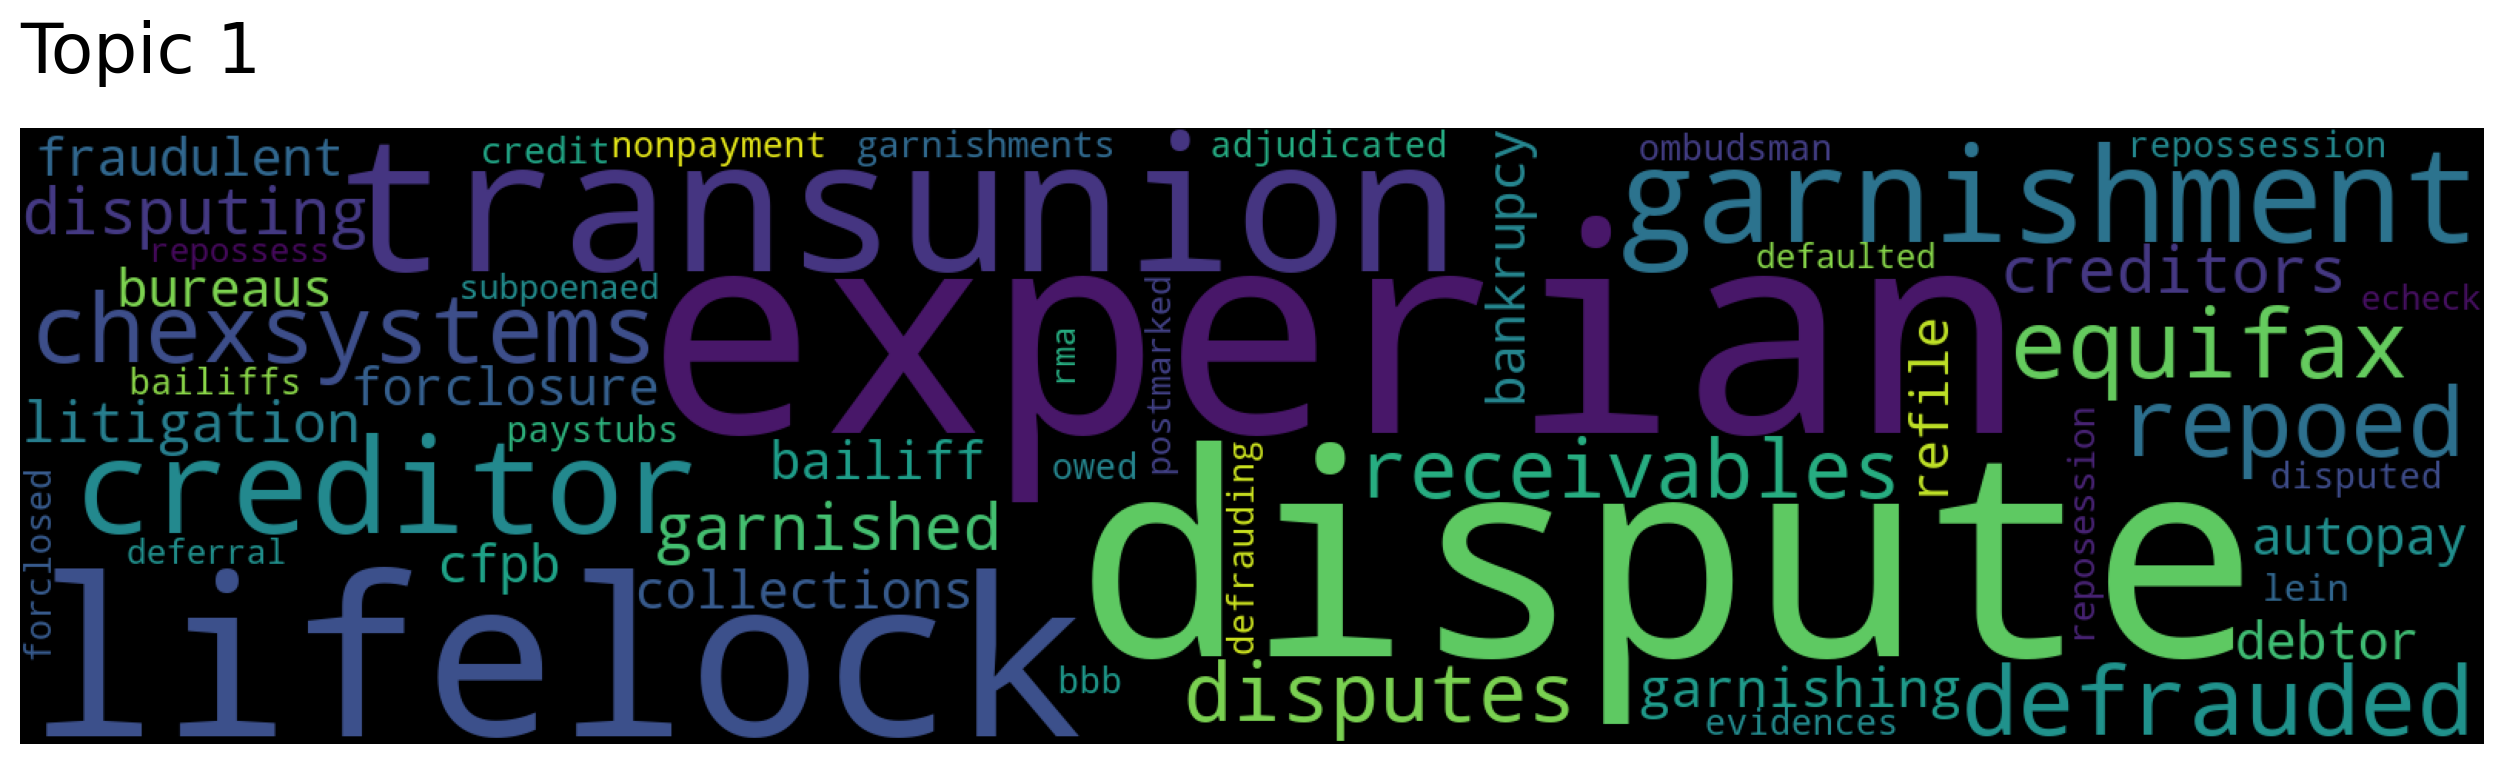

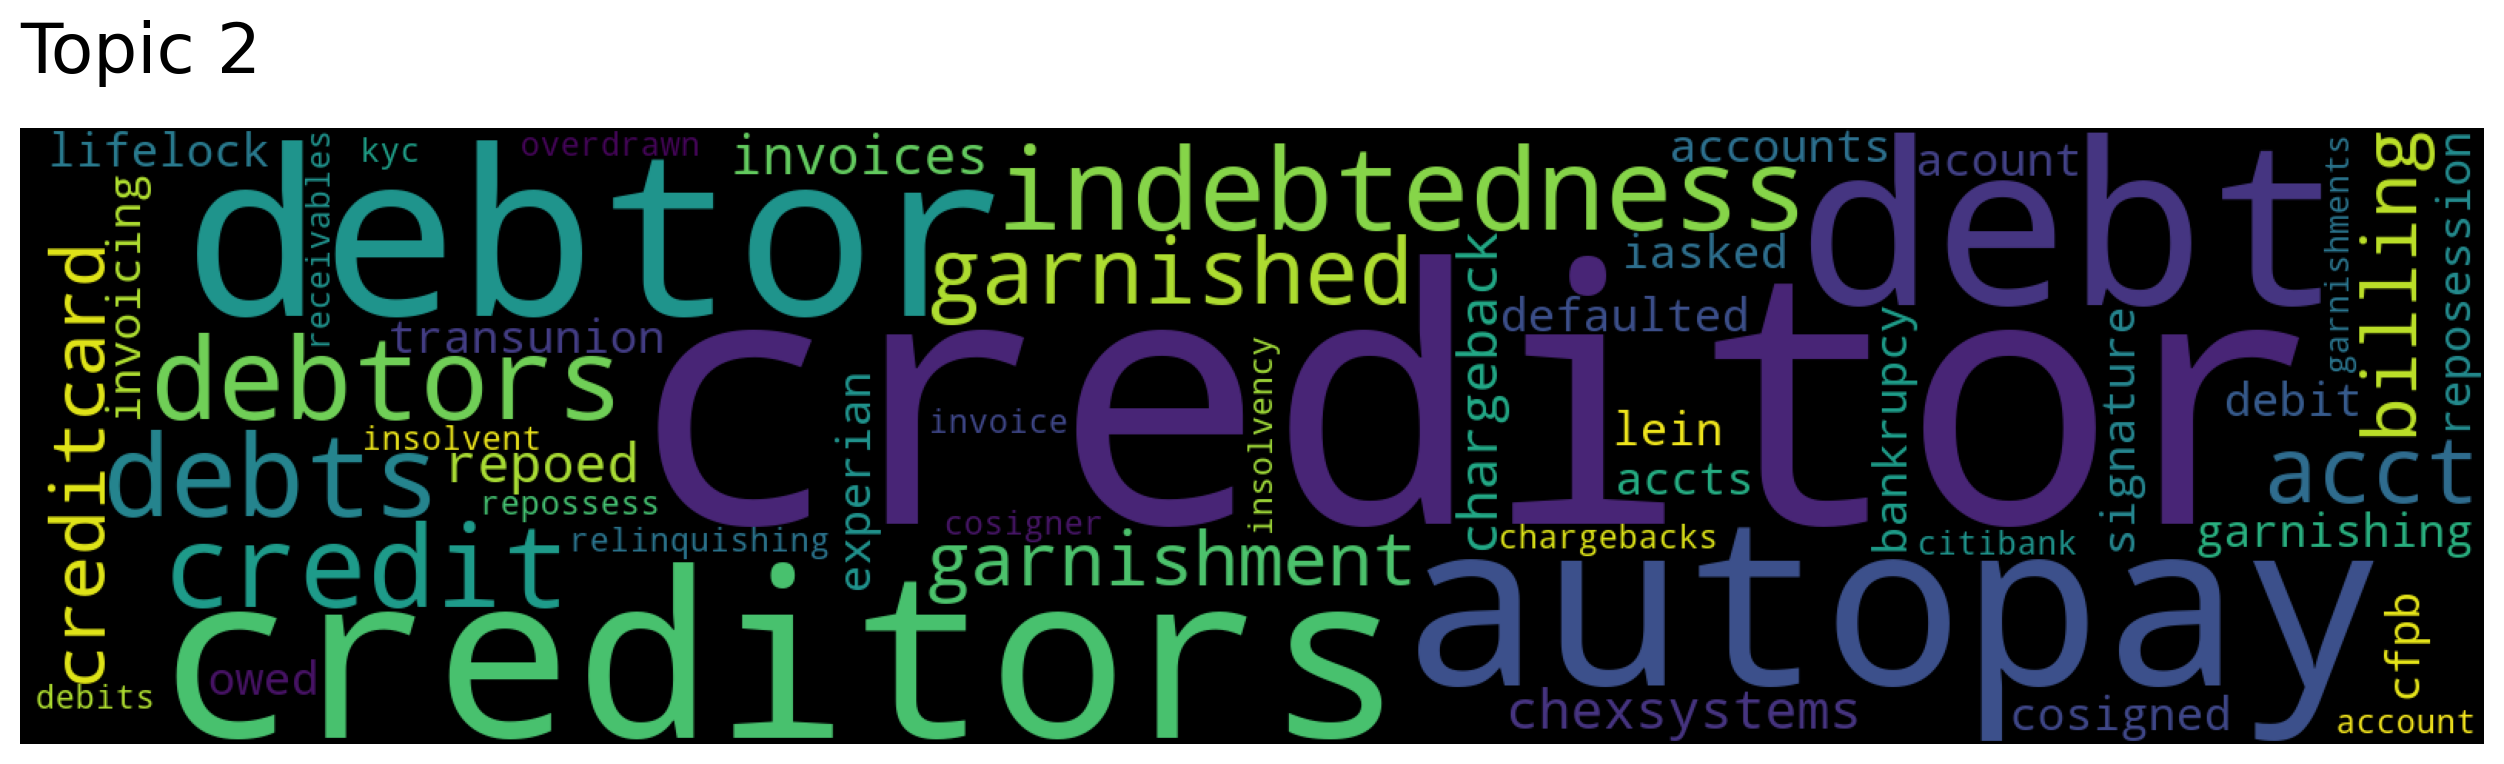

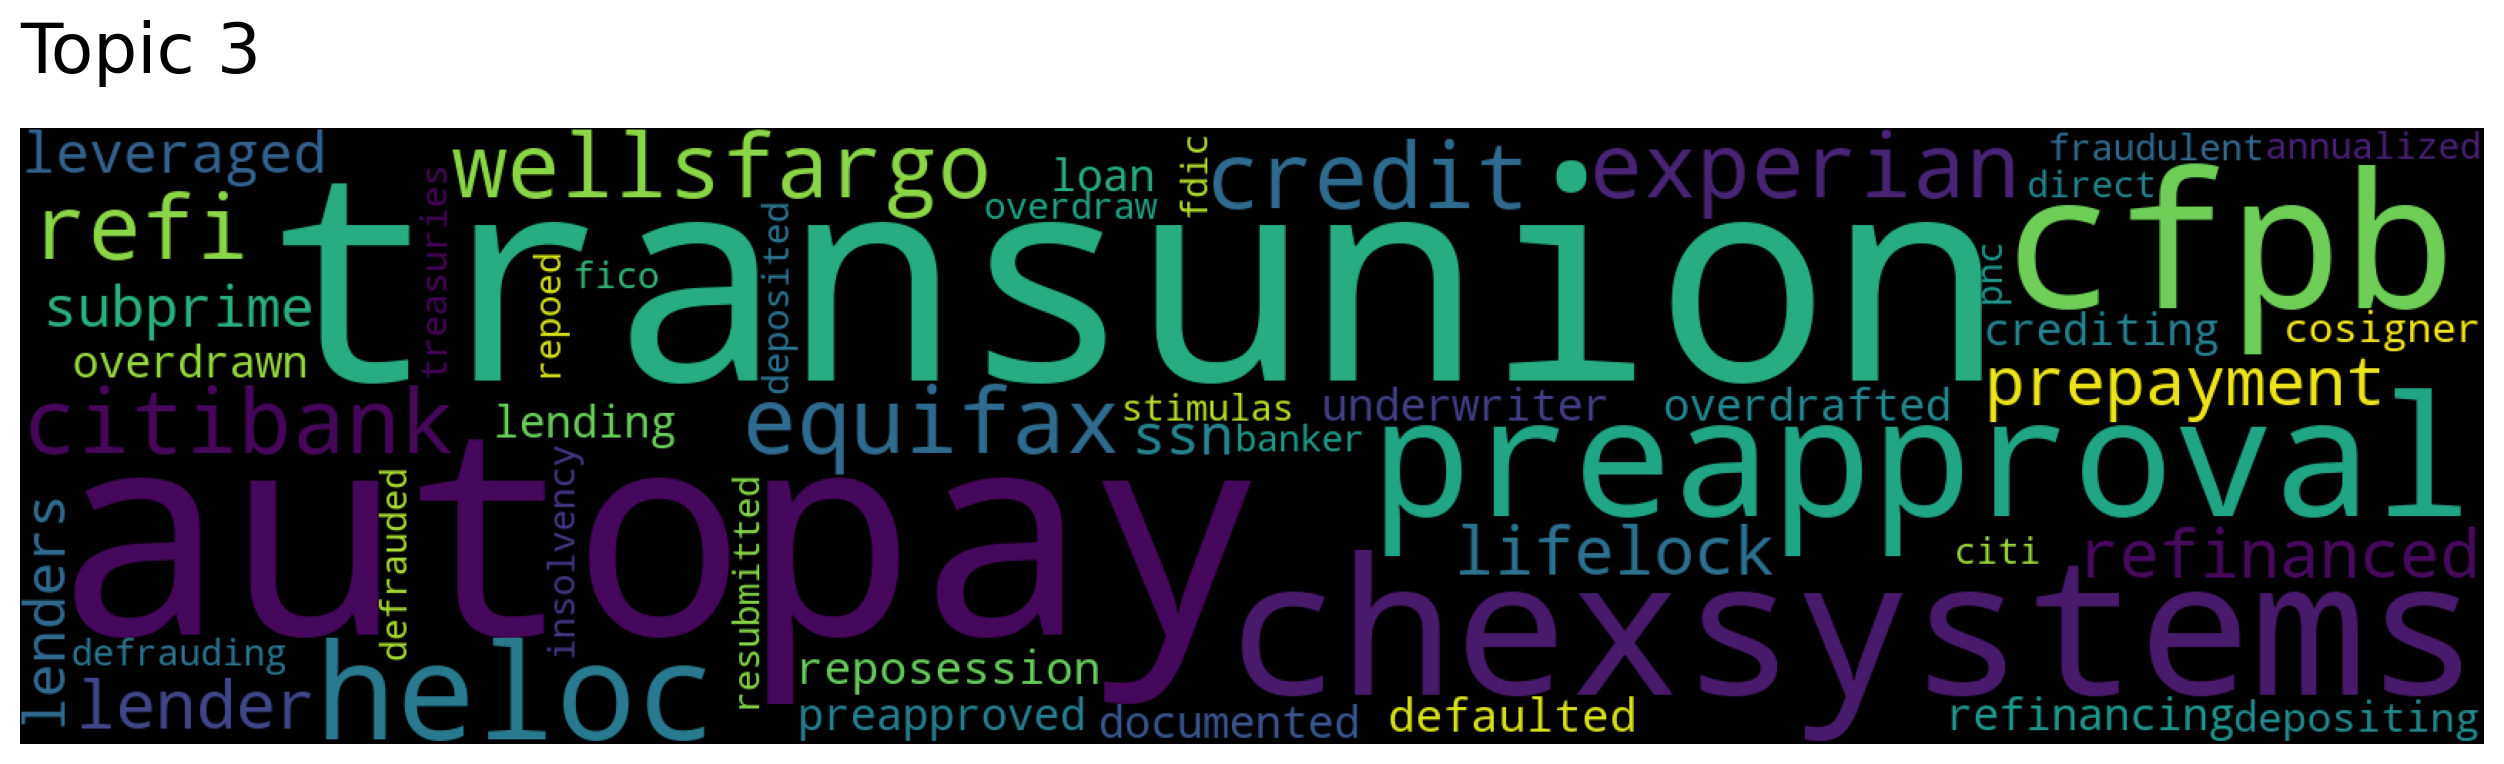

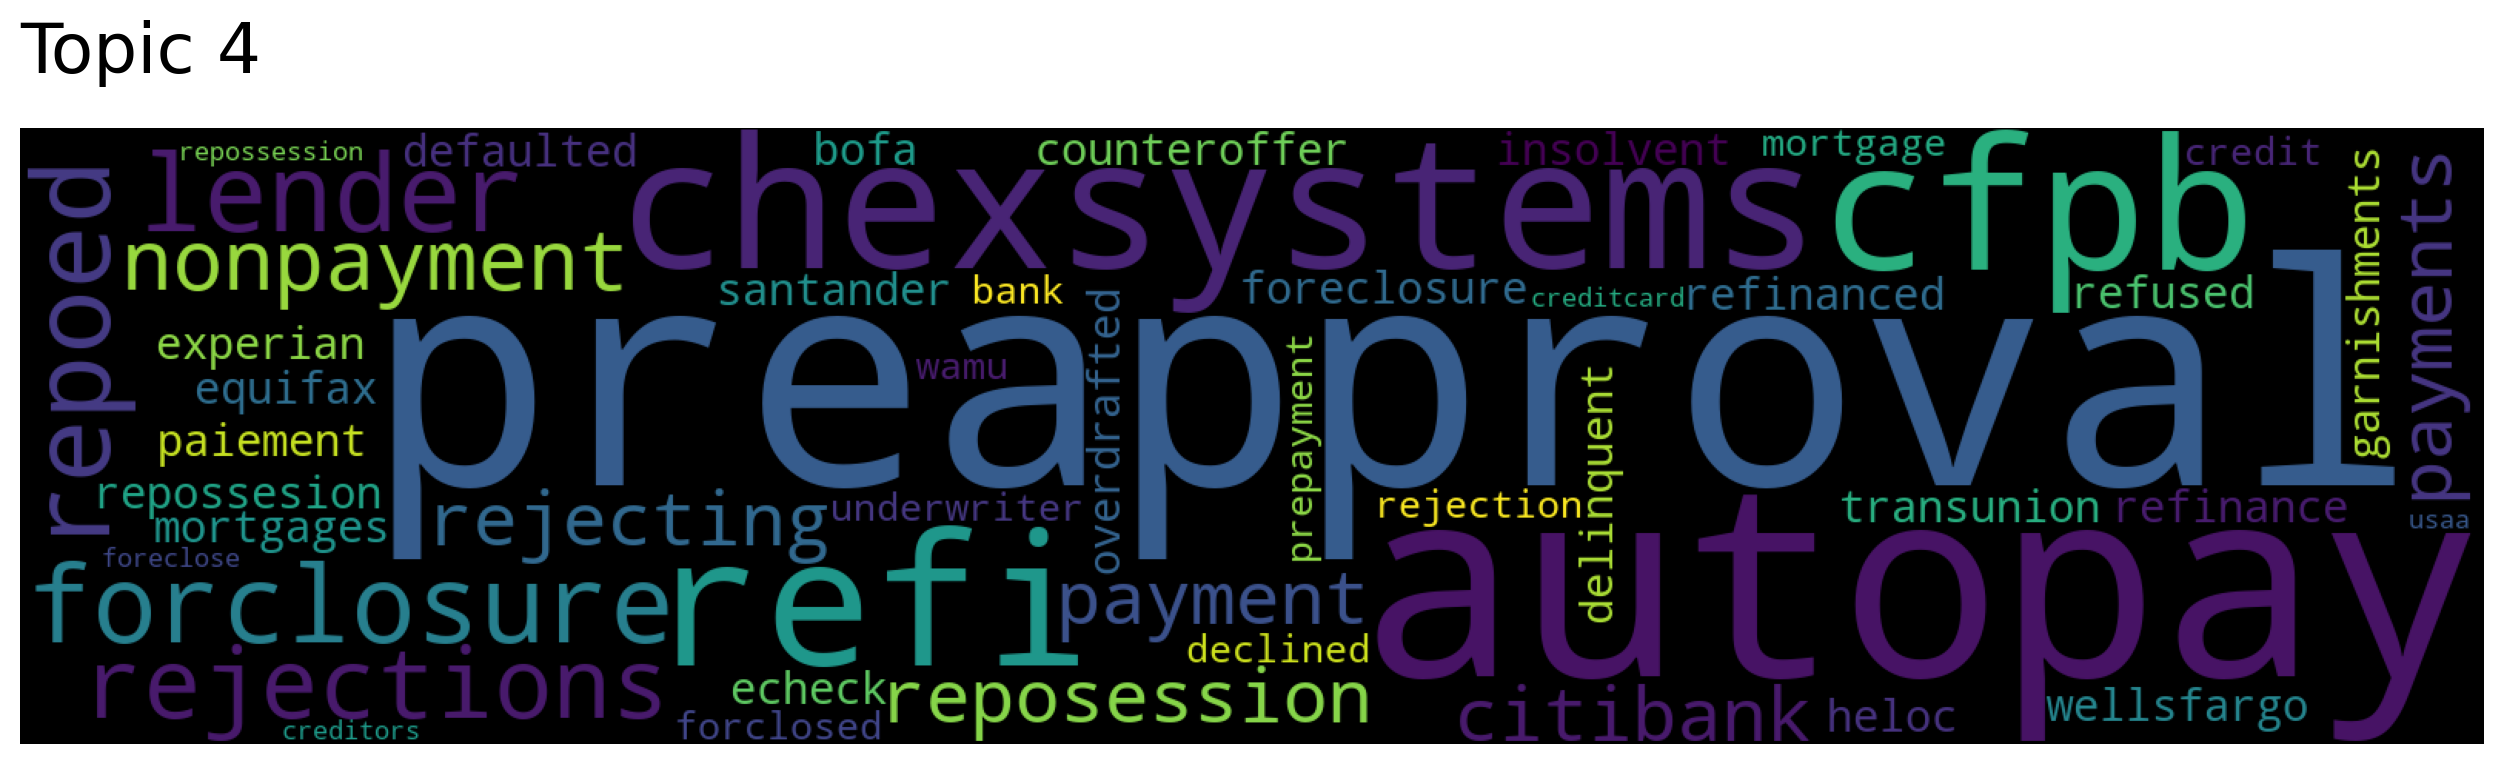

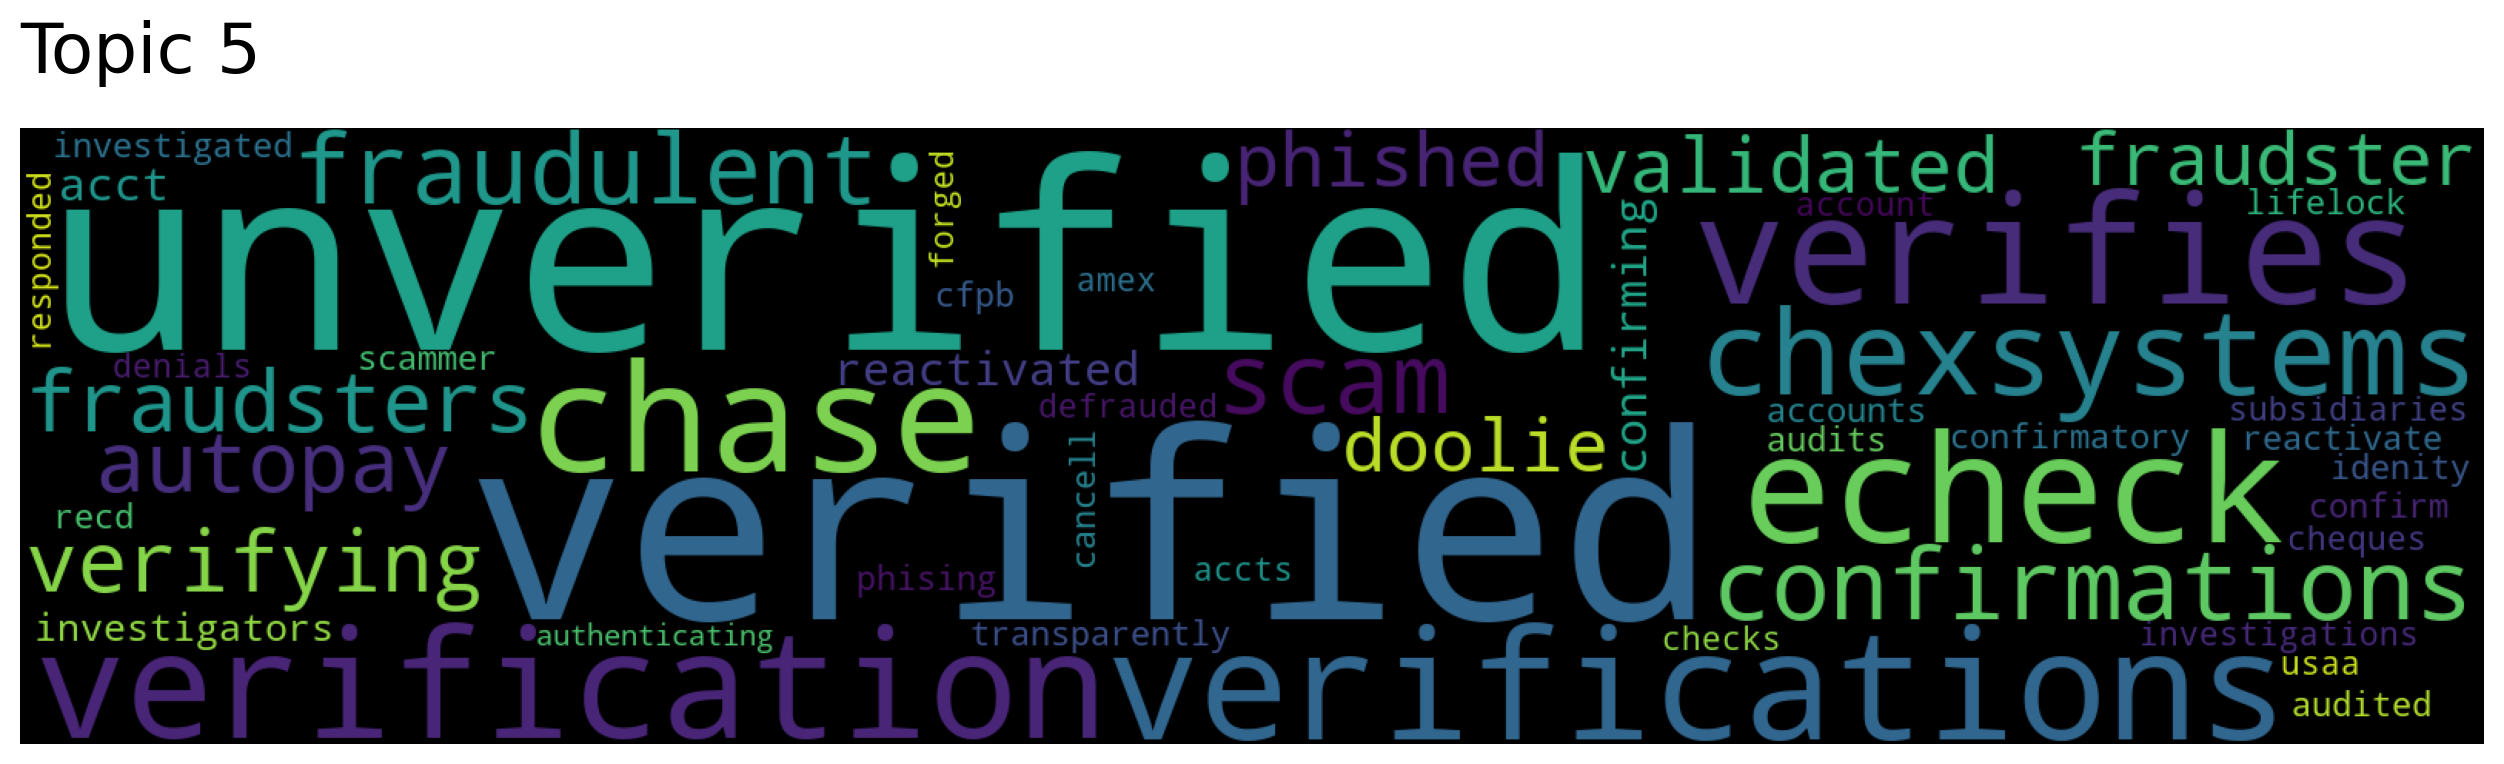

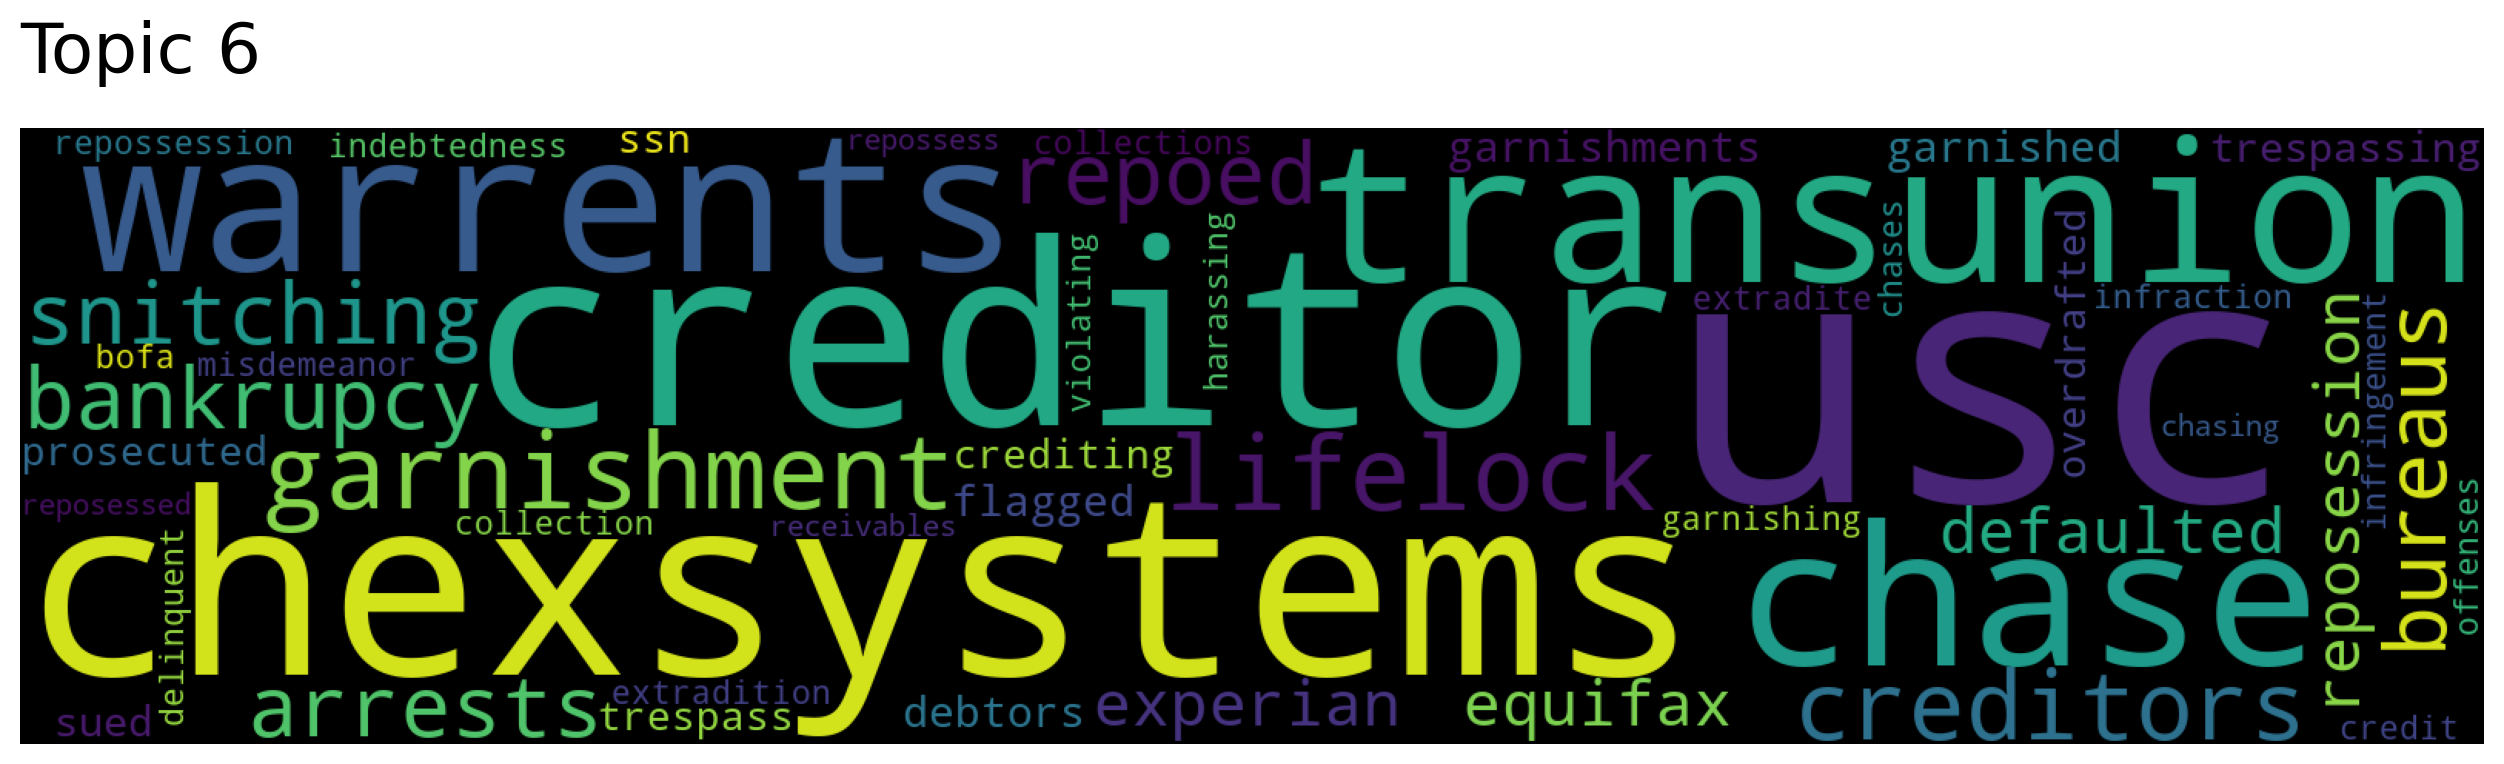

In [16]:
topic_words, word_scores, topic_nums = top2vec.get_topics(7)
for topic in topic_nums:
    top2vec.generate_topic_wordcloud(topic, background_color="black")

## BERTopic

In [20]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

# Instantiate the vectorizer model
vectorizer_model = CountVectorizer()

# Instantiate the UMAP model
umap_model = UMAP(n_neighbors=15, n_components=5, metric='cosine')

In [23]:
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=list(set(stopwords.words('english')))) #bigram, remove stopwords
docs = list(removed_mask)

bertopic = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=False,
    verbose=True,
    umap_model=umap_model)
topics, probs = bertopic.fit_transform(docs)

2024-06-03 01:13:16,389 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 659/659 [37:49<00:00,  3.44s/it] 
2024-06-03 01:51:13,259 - BERTopic - Embedding - Completed ✓
2024-06-03 01:51:13,270 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-03 01:51:31,654 - BERTopic - Dimensionality - Completed ✓
2024-06-03 01:51:31,663 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-03 01:51:36,508 - BERTopic - Cluster - Completed ✓
2024-06-03 01:51:36,558 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-03 01:51:53,600 - BERTopic - Representation - Completed ✓


In [24]:
vectorizer_model

CountVectorizer(ngram_range=(1, 2),
                stop_words=['ve', 'wasn', 'myself', 'our', 'don', "shouldn't",
                            'won', 'doing', 'was', 'with', 'the', 'off', 'this',
                            'have', "doesn't", 'can', 'did', 'ain', 'those',
                            'under', 'most', "that'll", 'down', 'on', 'were',
                            'm', 'do', 'between', 'hasn', 'yours', ...])

In [25]:
freq = bertopic.get_topic_info()
freq

bertopic.update_topics(docs, vectorizer_model=vectorizer_model) 

In [26]:
freq = bertopic.get_topic_info()
freq

Topic  Count                                             Name  \
0       -1  11610                     -1_chase_account_bank_credit   
1        0    699                        0_overdraft_fees_fee_3400   
2        1    676                        1_points_offer_card_bonus   
3        2    559                  2_inquiry_inquiries_hard_credit   
4        3    358                    3_loan_closing_rate_refinance   
..     ...    ...                                              ...   
130    129     10  129_corporate advance_mortgage_payment_payments   
131    130     10                 130_account_closure_money_branch   
132    131     10                 131_dispute_60_60 days_within 60   
133    132     10                       132_mortgage_deed_loan_som   
134    133     10                 133_merchant_dispute_case_repair   

                                        Representation  \
0    [chase, account, bank, credit, card, would, to...   
1    [overdraft, fees, fee, 3400, overdraft fees, c...   
2    [points, offer, card, bonus, annual, annual fe...   
3    [inquiry, inquiries, hard, credit, credit repo...   
4    [loan, closing, rate, refinance, mortgage, app...   
..                                                 ...   
130  [corporate advance, mortgage, payment, payment...   
131  [account, closure, money, branch, accounts, ba...   
132  [dispute, 60, 60 days, within 60, plan, credit...   
133  [mortgage, deed, loan, som, register deeds, de...   
134  [merchant, dispute, case, repair, car, transac...   

                                   Representative_Docs  
0    [This is my original complaint ( first paragra...  
1    [I opened my first Chase Back Checking account...  
2    [I originally submitted a complaint ( #  ; see...  
3    [Chase bank has a hard inquiry on my   credit ...  
4    [I believe I became a victim of a " bait and s...  
..                                                 ...  
130  [I email chase and ask them to explain why my ...  
131  [To whom it may concern : My name is   , I am ...  
132  [Chase bank charged back a credit for for a di...  
133  [I have a Satisfaction Of Mortgage that Dates ...  
134  [Hello, I took my car for service to mechanic ...  

[135 rows x 5 columns]

In [27]:
from hdbscan import HDBSCAN

model = BERTopic(nr_topics= 'auto',   
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=False,
    verbose=True,
    umap_model=umap_model)

hdbscan_model = HDBSCAN(min_cluster_size=10, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=5)
topic_model = BERTopic(hdbscan_model=hdbscan_model, 
                       nr_topics= 'auto')
topics, probs = topic_model.fit_transform(docs)

In [28]:
# Further reduce topics
freq = topic_model.get_topic_info()
freq

Topic  Count                              Name  \
0      -1   9859                  -1_the_to_and_my   
1       0   9335                   0_the_to_and_my   
2       1    174     1_bonus_coupon_account_direct   
3       2    124        2_calls_calling_phone_call   
4       3    112      3_title_lien_vehicle_release   
..    ...    ...                               ...   
57     56     10     56_marks_late_fcra_accurately   
58     57     10      57_results_havent_regards_30   
59     58     10     58_divorce_debt_cards_sailors   
60     59     10       59_30_thru_notified_website   
61     60     10  60_quarters_policy_bank_exchange   

                                       Representation  \
0    [the, to, and, my, that, was, chase, of, in, on]   
1    [the, to, and, my, that, chase, of, was, on, in]   
2   [bonus, coupon, account, direct, deposit, chec...   
3   [calls, calling, phone, call, number, stop, da...   
4   [title, lien, vehicle, release, co, jpmorgan, ...   
..                                                ...   
57  [marks, late, fcra, accurately, 3060, reported...   
58  [results, havent, regards, 30, incorrect, item...   
59  [divorce, debt, cards, sailors, soldiers, beli...   
60  [30, thru, notified, website, always, paid, mo...   
61  [quarters, policy, bank, exchange, tender, cur...   

                                  Representative_Docs  
0   [Hi, my name is  . On    i received a letter f...  
1   [In an email I sent to my personal Chase banke...  
2   [Chase Bank is advertising a {$200.00} bonus f...  
3   [The calls are from card member service, they ...  
4   [I am filling a complaint against   /JPMorgan ...  
..                                                ...  
57  [I see multiple 30-60 days late marks which is...  
58  [I filed a dispute in regards to the incorrect...  
59  [I took out credit card as a . The card had a ...  
60  [I have always paid my account on time every m...  
61  [On //, I deposited the sum of {$500.00} into ...  

[62 rows x 5 columns]

In [29]:
topic_model.update_topics(docs, vectorizer_model=vectorizer_model) 
freq = topic_model.get_topic_info()

In [30]:
freq.head()

Topic  Count                           Name  \
0     -1   9859   -1_chase_account_bank_credit   
1      0   9335    0_chase_credit_account_card   
2      1    174  1_bonus_coupon_account_direct   
3      2    124     2_calls_calling_phone_call   
4      3    112  3_title_lien_chase co_vehicle   

                                      Representation  \
0  [chase, account, bank, credit, card, would, to...   
1  [chase, credit, account, card, bank, would, pa...   
2  [bonus, coupon, account, direct, deposit, dire...   
3  [calls, calling, phone, call, number, stop, da...   
4  [title, lien, chase co, vehicle, release, co, ...   

                                 Representative_Docs  
0  [Hi, my name is  . On    i received a letter f...  
1  [In an email I sent to my personal Chase banke...  
2  [Chase Bank is advertising a {$200.00} bonus f...  
3  [The calls are from card member service, they ...  
4  [I am filling a complaint against   /JPMorgan ...